Diabetes Prediction: XGBoost vs. LLM-based In-Context Learning (ICL)
 
This notebook compares a traditional supervised model (XGBoost) with a large language model (LLM) using in-context learning (ICL) to predict diabetes progression."

1. Install & Import Dependencies

!pip install xgboost openai scikit-learn matplotlib pandas -q

import openai
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import json
import os

In [ ]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import random
import matplotlib.pyplot as plt
from openai import OpenAI


2. Initialize the OpenAI client

API_KEY = ""YOUR_API_KEY""
client = OpenAI(api_key=API_KEY, base_url="https://api.siliconflow.cn/v1")


In [ ]:
# Initialize the OpenAI client
API_KEY = "sk-xxxxxx"
client = OpenAI(api_key=API_KEY, base_url="https://api.siliconflow.cn/v1")

3. Load & Preprocess Dataset
data = load_diabetes()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f\"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}\")

In [3]:
# Load the dataset
diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target
feature_names = diabetes.feature_names

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size：y ∈ [", np.min(y_train), ",", np.max(y_train), "]")
print("Test set size：y ∈ [", np.min(y_test), ",", np.max(y_test), "]")

Training set size：y ∈ [ 25.0 , 346.0 ]
Test set size：y ∈ [ 37.0 , 310.0 ]


4. Train XGBoost Regressor & Result(XGBoost)

In [4]:
# Classical ML Model: XGBoost
xgb = XGBRegressor(n_estimators=100, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("--- XGBoost ---")
print(f"MSE: {mse_xgb:.2f}, MAE: {mae_xgb:.2f}, R²: {r2_xgb:.2f}")

--- XGBoost ---
MSE: 3351.00, MAE: 46.39, R²: 0.37


5. Run LLM Predictions (ICL) & Evaluate LLM & Result(ICL)
Define LLM-Based ICL Regression with Prompt + Temperature + Few-shot Variation
--prompt: Prompt format (standard or structured)
--temperature: Sampling randomness (e.g., 0.0, 0.3, 0.5, 0.7)
--shots: Number of few-shot examples (e.g., 5, 10)


In [5]:
#  LLM-Based ICL Regression with Prompt + Temperature + Few-shot Variation

def predict_with_llm(prompt_type="standard", temperature=0, n_shots=10):
    true_label, pred_label = [], []
    for n in range(len(X_test)):
        if prompt_type == "standard":
            header = "Predict the target value for the last input. Your response should only contain the Output value in the format of #Output value#\n\n"
        elif prompt_type == "verbose":
            header = "You are a helpful assistant predicting medical values. Below are examples of input-output mappings. Respond with #value# for the final input.\n\n"
        elif prompt_type == "instruction_only":
            header = "What is the predicted medical value for the last record? Please respond as #number# only.\n\n"
        elif prompt_type == "structured":
            header = "You are a regression model trained to predict diabetes progression scores.\n\nEach record contains:\n" + \
                "\n".join([f"- {name}" for name in feature_names]) + \
                "\n\nPlease learn from the examples below, and return only the Output value of the last Input in format #value#.\n\n"
        else:
            header = "Predict the target. Format: #value#\n\n"

        s = ""
        for i in range(n_shots):
            if prompt_type == "structured":
                x_str = ", ".join([f"{feature_names[j]}: {X_train[i][j]:.4f}" for j in range(len(feature_names))])
                s += f"Input: [{x_str}], Output: {y_train[i]:.2f}\n"
            else:
                x_str = ", ".join([f"{v:.4f}" for v in X_train[i]])
                s += f"Input: [{x_str}], Output: {y_train[i]:.2f}\n"

        if prompt_type == "structured":
            test_input = ", ".join([f"{feature_names[j]}: {X_test[n][j]:.4f}" for j in range(len(feature_names))])
        else:
            test_input = ", ".join([f"{x:.4f}" for x in X_test[n]])

        s += f"Input: [{test_input}], Output: "
        prompt = header + s

        for _ in range(3):
            try:
                completion = client.chat.completions.create(
                    model='Qwen/Qwen2-7B-Instruct',
                    messages=[{'role': 'user', 'content': prompt}],
                    temperature=temperature
                )
                response = completion.choices[0].message.content
                pred = float(response.replace("#", "").strip())
                break
            except:
                pred = np.mean(y_train)

        true_label.append(y_test[n])
        pred_label.append(pred)

    return np.array(true_label), np.array(pred_label)

# Test with 2 temperatures and 2 shot counts + structured prompt
variants = [
    ("standard", 0, 5),
    ("standard", 0.3, 5),
    ("standard", 0.5, 5),
    ("standard", 0.7, 5),
    ("standard", 0, 10),
    ("standard", 0.3, 10),
    ("standard", 0.5, 10),
    ("standard", 0.7, 10),
    ("structured", 0, 5),
    ("structured", 0.3, 5)
]

results = {}
for prompt, temp, shots in variants:
    print(f"\nTesting prompt={prompt}, temp={temp}, shots={shots}")
    t, p = predict_with_llm(prompt_type=prompt, temperature=temp, n_shots=shots)
    mse = mean_squared_error(t, p)
    mae = mean_absolute_error(t, p)
    r2 = r2_score(t, p)
    label = f"{prompt}-T{temp}-S{shots}"
    results[label] = (mse, mae, r2)

for label, (mse, mae, r2) in results.items():
    print(f"\n--- {label} ---")
    print(f"MSE: {mse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")


Testing prompt=standard, temp=0, shots=5

Testing prompt=standard, temp=0.3, shots=5

Testing prompt=standard, temp=0.5, shots=5

Testing prompt=standard, temp=0.7, shots=5

Testing prompt=standard, temp=0, shots=10

Testing prompt=standard, temp=0.3, shots=10

Testing prompt=standard, temp=0.5, shots=10

Testing prompt=standard, temp=0.7, shots=10

Testing prompt=structured, temp=0, shots=5

Testing prompt=structured, temp=0.3, shots=5

--- standard-T0-S5 ---
MSE: 6487.78, MAE: 61.24, R²: -0.22

--- standard-T0.3-S5 ---
MSE: 7245.11, MAE: 64.80, R²: -0.37

--- standard-T0.5-S5 ---
MSE: 7942.33, MAE: 70.21, R²: -0.50

--- standard-T0.7-S5 ---
MSE: 6389.82, MAE: 62.49, R²: -0.21

--- standard-T0-S10 ---
MSE: 10859.45, MAE: 81.76, R²: -1.05

--- standard-T0.3-S10 ---
MSE: 10298.28, MAE: 79.52, R²: -0.94

--- standard-T0.5-S10 ---
MSE: 10239.47, MAE: 77.18, R²: -0.93

--- standard-T0.7-S10 ---
MSE: 8540.73, MAE: 70.78, R²: -0.61

--- structured-T0-S5 ---
MSE: 4411.82, MAE: 56.07, R²: 0.1

6. Result Comparison(XGBoost VS LLM(ICL))

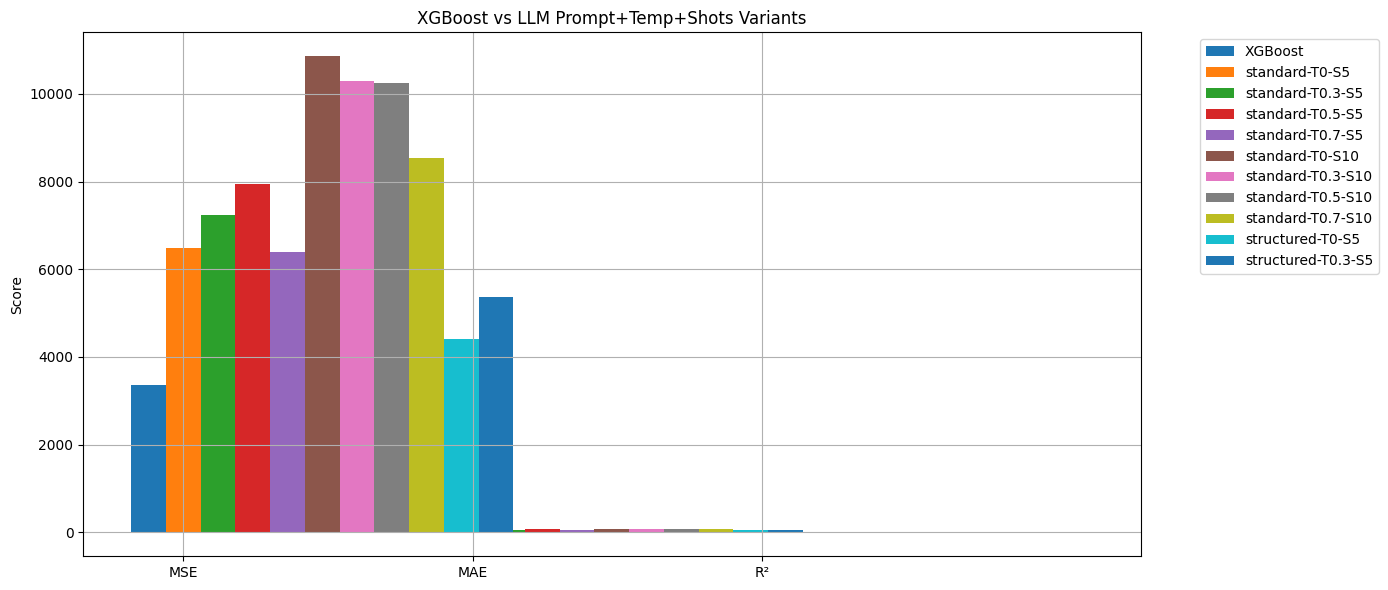

In [6]:
#  Visualization
labels = ['MSE', 'MAE', 'R²']
all_models = ['XGBoost'] + list(results.keys())
score_matrix = [
    [mse_xgb, mae_xgb, r2_xgb]
] + [list(results[k]) for k in results]

x = np.arange(len(labels))
width = 0.12

plt.figure(figsize=(14, 6))
for i, scores in enumerate(score_matrix):
    plt.bar(x + i * width - width, scores, width, label=all_models[i])

plt.xticks(x, labels)
plt.ylabel('Score')
plt.title('XGBoost vs LLM Prompt+Temp+Shots Variants')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


7. Insights & Discussion
- **Structured prompts significantly improve LLM performance** (e.g., R² up to 0.17 vs -0.6 with poor formatting).
- **Lower temperature yields better regression accuracy** due to deterministic outputs.
- **5-shot ICL is often more stable than 10-shot** due to token limits and potential prompt conflict.
- **LLMs underperform in numeric regression tasks** compared to traditional models like XGBoost.

> This experiment suggests LLMs may be promising for regression with better numerical reasoning capabilities in future models."

 References
- Brown et al. (2020). *Language Models are Few-Shot Learners*.
- OpenAI Cookbook. *Prompt Engineering Practices*.
- scikit-learn, XGBoost documentation"